# EDA Details

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sn

pd.set_option('display.max_columns', None)

import os
plot_path = 'EDA_plots'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)


Before our analysis, we need to know which featues in the SRA run table are more suitable to put in our model and get familliar with the gene matrix we have. To do this, we need to perform exploratory data analysis on the SRA run table and the gene matrix. 


## SRA run table

First, let us explore the SRA run table. Because there are too many features in this table, we selected only the columns that are relevant to our analysis (shown below).

As a reference, here are the brief introductions of some of the domain-specific features:

* NIA-R: The modified NIA-Reagan diagnosis of Alzheimer's disease is based on consensus recommendations for postmortem diagnosis of Alzheimer's disease. The criteria rely on both neurofibrillary tangles (Braak) and neuritic plaques (CERAD).


* LB stage: Lewy body dementia, also known as dementia with Lewy bodies, is the second most common type of progressive dementia after Alzheimer's disease dementia. Protein deposits, called Lewy bodies, develop in nerve cells in the brain regions involved in thinking, memory and movement (motor control). There are two diagnoses of LBD—dementia with Lewy bodies (DLB) and Parkinson's disease dementia. The earliest signs differ but reflect the same biological changes in the brain. Over time, people with dementia with Lewy bodies or Parkinson's disease dementia may develop similar symptoms.


* Braak staging refers to two methods used to classify the degree of pathology in Parkinson's disease and Alzheimer's disease. These methods are used both in research and for the clinical diagnosis of these diseases and are obtained by performing an autopsy of the brain.

In [61]:
features = ['expired_age', 'sex', 'PMI', 'sn_depigmentation', 'Braak score', 'TangleTotal', 'Plaque density', 
            'PlaqueTotal', 'CONDITION', 'DiseaseDuration','BIOFLUID', 'TRANSCRIPTOME READS', 'REFERENCE GENOME READS', 
            'TRANSCRIPTOME GENOME RATIO', 'PlaqueF', 'PlaqueT', 'PlaqueH', 'PlaqueE', 'TangleF', 
            'TangleT', 'TangleH', 'TangleE', 'NIA-R', 'LB Stage', 'Run']

In [62]:
sra = pd.read_csv('../test/testdata/SraRunTable.csv', usecols=features)
sra.head()

,CONDITION,BIOFLUID,TRANSCRIPTOME READS,REFERENCE GENOME READS,TRANSCRIPTOME GENOME RATIO,expired_age,DiseaseDuration,PMI,PlaqueF,PlaqueT,PlaqueH,PlaqueE,PlaqueTotal,Plaque density,TangleF,TangleT,TangleH,TangleE,TangleTotal,Braak score,NIA-R,LB Stage,sn_depigmentation,Run,sex
0,Healthy Control,Cerebrospinal fluid,6883461,6923368,0.994236,94,8.0,2.50,3.0,3.00,3.0,3.0,15.00,frequent,1.0,3.00,3.0,3.0,12.00,IV,criteria not met,No Lewy bodies,none,SRR1568567,male
1,Parkinson's Disease,Serum,2904451,2953867,0.983271,79,1.0,6.00,0.0,1.75,0.0,0.0,2.75,sparse,0.0,0.75,1.5,1.0,3.25,II,criteria not met,Limbic type,severe,SRR1568730,female
2,Alzheimer's Disease,Serum,12132405,12781881,0.949188,81,7.0,2.50,2.5,2.50,2.5,2.0,11.50,frequent,1.6,2.50,3.0,3.0,11.10,V,high,No Lewy bodies,mild,SRR1568666,female
3,Parkinson's Disease,Cerebrospinal fluid,5560256,5622788,0.988879,79,4.0,2.50,1.5,2.00,1.0,1.5,7.50,moderate,0.0,0.50,1.0,1.5,3.00,II,low,Neocortical type,severe,SRR1568510,male
4,Parkinson's Disease,Cerebrospinal fluid,12131859,12219540,0.992825,82,18.0,4.16,0.0,0.00,0.0,0.0,0.00,zero,0.0,0.50,3.0,3.0,6.50,III,criteria not met,Limbic type,severe,SRR1568518,female


Here is how many samples we have for each group

In [58]:
sra.CONDITION.value_counts().to_frame()

,CONDITION
Healthy Control,126
Alzheimer's Disease,110
Parkinson's Disease,107


### Uniqueness of the Data

The first question is that does each subject has both cerebrospinal fluid and serum sample? Or there is only one sample from a single area of interest for one subject?

As we can see in the figure below, the anwser is the latter. So we need to keep in mind that there may exist cross-subject differences for samples of different biofluids

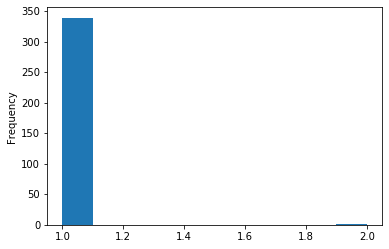

In [4]:
# Do all subjects have both CSF and serum?

# Different population
fig = sra.Run.value_counts().plot.hist().get_figure()
fig.savefig(os.path.join(plot_path, 'sample_uniqueness.png'))

### Gender & Condition Breakdown

So, we broke down the samples into two groups based on biofluid, and then looked at the distribution of other variables, namely gender, expired age, PMI, total number of plaques, and total number of tangles.

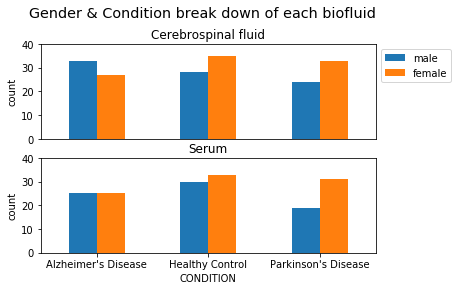

In [5]:
#sample furthur break-down by gender
cnt_summary_CSF = sra[sra['BIOFLUID']=='Cerebrospinal fluid'][['CONDITION', 'BIOFLUID', 'sex']].groupby(['CONDITION', 'sex']).count().unstack()
cnt_summary_serum = sra[sra['BIOFLUID']=='Serum'][['CONDITION', 'BIOFLUID', 'sex']].groupby(['CONDITION', 'sex']).count().unstack()
fig, (ax1, ax2) = plt.subplots(2, 1)
cnt_summary_CSF.plot.bar(ax = ax1)
ax1.legend(['male', 'female'], bbox_to_anchor=(1, 1))
ax1.set_title('Cerebrospinal fluid')
ax1.set_ylim(0,40)
ax1.set_ylabel('count')
ax1.xaxis.set_visible(False)

cnt_summary_serum.plot.bar(ax = ax2)
ax2.set_title('Serum')
ax2.legend().remove()
ax2.set_ylim(0,40)
ax2.set_ylabel('count')
plt.xticks(rotation = 0)
fig.suptitle('Gender & Condition break down of each biofluid', fontsize='x-large')
fig.subplots_adjust(top=0.85)

fig.savefig(os.path.join(plot_path, 'gender_cond_biofluid.png'))

### Numerical Variables Distribution

/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


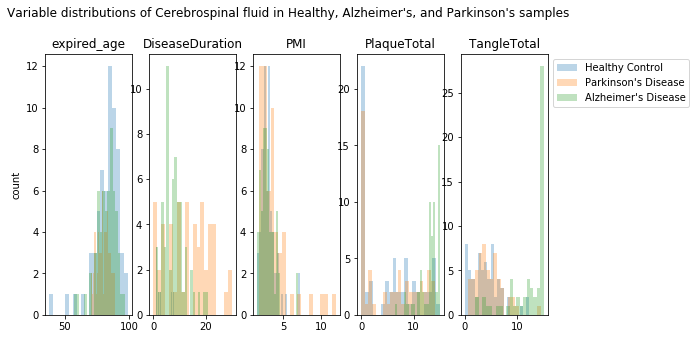

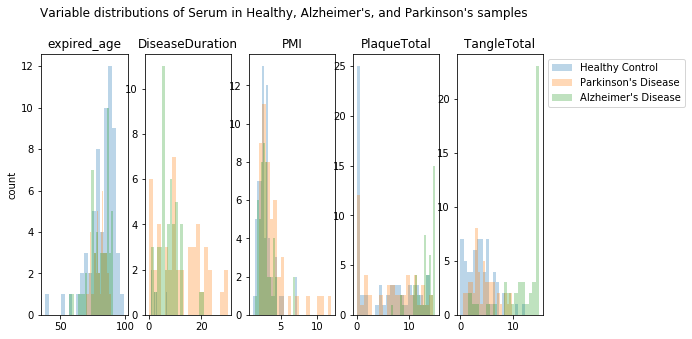

In [63]:
conditions = sra.CONDITION.unique()
biofluids = sra.BIOFLUID.unique()
num_bins = 20
variables = ['expired_age', 'DiseaseDuration', 'PMI', 'PlaqueTotal', 'TangleTotal']
for i in biofluids:
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
    fig.set_figheight(5)
    fig.set_figwidth(9)
    ax_arr = [ax1, ax2, ax3, ax4, ax5]
    fig.suptitle('Variable distributions of %s in Healthy, Alzheimer\'s, and Parkinson\'s samples' % i)
    fig.subplots_adjust(top=0.85)
    for j in conditions:
        for k in range(len(variables)):
            data = sra.loc[(sra['CONDITION']==j) & (sra['BIOFLUID']==i)][variables[k]]
            ax = ax_arr[k]
            ax.hist(data, bins=num_bins,label=j, alpha = 0.3)
            ax.set_title(variables[k])
            if k==0:
                ax.set_ylabel('count')
        ax.legend(bbox_to_anchor=(1, 1))
            
    fig.savefig(os.path.join(plot_path, 'num_variable_distr_%s.png'%i))  

As shown above, although the distributions have slight differences, the distinction between the distribution of the samples of cerebrospinal fluid and that of serum is not significant. 

As mentioned previously, NIA-R is a measurement for diagnosing Alzheimer's disease. We wanted to validate if the values of the samples in our dataset reflect this claim.

### Distribution of NIA-R Broken Down By Conditions

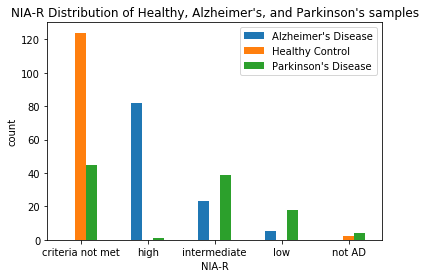

In [7]:
# distribution of NIA-R droken down by conditions

conditions = ['Alzheimer\'s Disease', 'Healthy Control', 'Parkinson\'s Disease']
nia_r = sra.groupby(['NIA-R','CONDITION']).size().to_frame()
nia_r.unstack().plot(kind='bar')
plt.legend(conditions)
plt.xticks(rotation = 0)
plt.ylabel('count')
plt.title('NIA-R Distribution of Healthy, Alzheimer\'s, and Parkinson\'s samples')
plt.savefig(os.path.join(plot_path, 'NIA-R.png'))

In the chart above, we saw that all the healthy control samples are either under the category "criteria not met" or "no AD". Surprisingly, although it is expected that most of the AD samples are under the category "high" there are some of the PD samples under "intermediate" and "low" categories. It might suggest that there exist some commonalities between AD and PD.


Then we did the similar thing for other measurements like LB stage, Substantia Nigra Depigmentation, and Braak score.

### Distribution of LB Stage Broken Down By Conditions

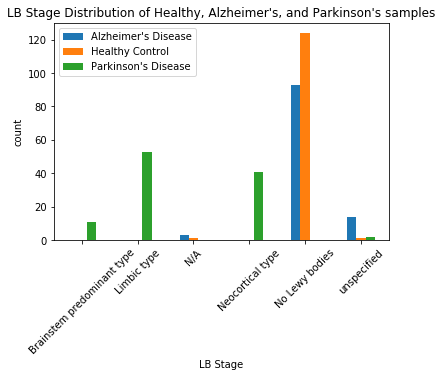

In [8]:
# distribution of LB Stage broken down by conditions
lb_mapper = {'LB pathology unspecified or not further assessed': 'unspecified', np.nan: 'N/A'}
sra['LB Stage'] = sra['LB Stage'].replace(lb_mapper)
lb_stage = sra.groupby(['LB Stage', 'CONDITION']).size().to_frame()
lb_stage.unstack().plot(kind='bar')
plt.legend(conditions)
plt.xticks(rotation = 45)
plt.ylabel('count')
plt.title('LB Stage Distribution of Healthy, Alzheimer\'s, and Parkinson\'s samples')
plt.savefig(os.path.join(plot_path, 'LB_stage.png'))

Since lewy bodies are closely associated with Parkinson's disease, it is reasonable to see there are only Parkinson's samples in the LB stage categories. Among those samples, most of them are under limbic type and neocortical type. Under "No lewy bodies" category, there are no Parkinson's patients, which further proved that lewy bodies is specific to Parkinson's disease in our dataset.

### Distribution of SN Depigmentation Broken Down By Conditions

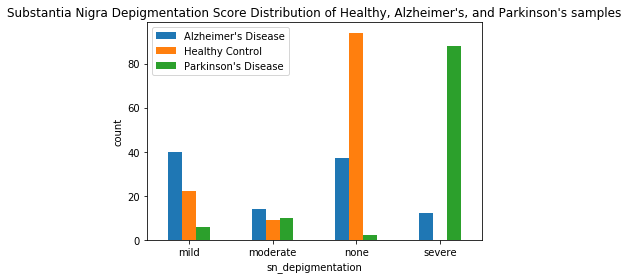

In [9]:
# sn depigmentation distributions broken down by conditions
conditions = ['Alzheimer\'s Disease', 'Healthy Control', 'Parkinson\'s Disease']
sn_dp = sra.groupby(['sn_depigmentation', 'CONDITION']).size().to_frame()
sn_dp.unstack().plot(kind='bar')
plt.legend(conditions)
plt.xticks(rotation = 0)
plt.ylabel('count')
plt.title('Substantia Nigra Depigmentation Score Distribution of Healthy, Alzheimer\'s, and Parkinson\'s samples')
plt.savefig(os.path.join(plot_path, 'sn_depigmentation.png'))

According to [Peowe et al.](https://www.nature.com/articles/nrdp201713#Sec3), compared to control, parkinson's disease is defined by sn depigmentation. So it is intuitive to see the parkinson's group has the most severe cases. However, same as what happened in NIA-R distribution, there is not a clear separation between AD and PD, namely, there are still some AD patients in the "mild", "moderate", or even "severe" categories.


(Poewe, W., Seppi,K., Tanner, C. et al. Parkinson disease. Nat Rev Dis Primers 3, 17013 (2017). https://doi.org/10.1038/nrdp.2017.13)

### Distribution of Braak Score Broken Down By Conditions

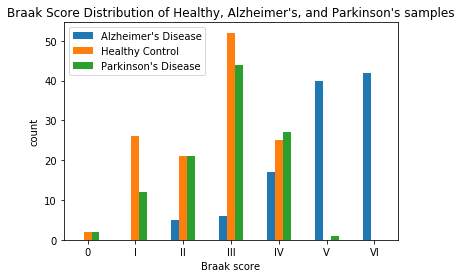

In [10]:
#braak distribution
conditions = ['Alzheimer\'s Disease', 'Healthy Control', 'Parkinson\'s Disease']
bs_cnts = sra.groupby(['Braak score','CONDITION']).size().to_frame()
bs_cnts.unstack().plot(kind='bar')
plt.legend(conditions)
plt.xticks(rotation = 0)
plt.ylabel('count')
plt.title('Braak Score Distribution of Healthy, Alzheimer\'s, and Parkinson\'s samples')
plt.savefig(os.path.join(plot_path, 'Braak_score.png'))

As mentioned in the beginning of the notebook, braak score is used to classify the degree of pathology in both PD and AD. However, in our dataset, although we can see a clearly different distribution for AD patients (the count increases as the stages go higher), there is no clear separation between the PD patients and the healthy control. It could be the case that this is what the data should look like, but we cannot exclude the possibility that there is something wrong with this feature (like wrong data entry, unspecified standard changes, etc..)

### Tangle & Plaque Counts Distribution in Each Brain Region Broken Down By Conditions

Because some of the categorical features above could not clearly divide groups, we wanted to see if the numerical features can achieve this separation.

Since tangles and plaques are important markers for AD, we are hoping to see different distribution of plaques and tangles in the AD group. In addition, we also wanted to know if the influence of disorder differs across brain regions. Therefore, we chose four brain regions(Frontal, Temporal, Hippocampal, and Entorhinal) and plotted the distributions of plaques and tangles of all three groups respectively.

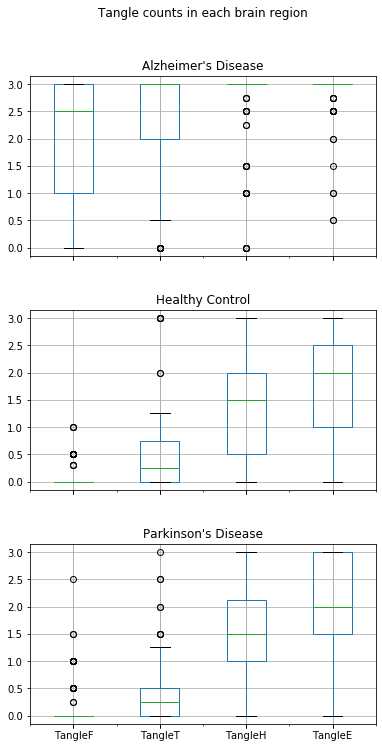

In [11]:
# Tangle counts distribution in each brain region broken down by contidions
plaques = sra[['CONDITION', 'TangleF', 'TangleT', 'TangleH', 'TangleE']]
plaques.groupby('CONDITION').boxplot(figsize=(6, 12), layout=(3, 1), sharex=True)
plt.subplots_adjust(hspace = 0.3)
plt.suptitle('Tangle counts in each brain region')
plt.savefig(os.path.join(plot_path, 'tangle_counts.png'))

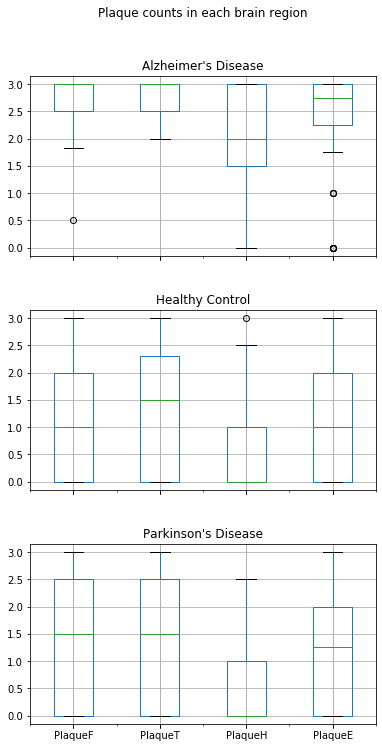

In [12]:
# Plaque counts distribution in each brain region broken down by contidions
plaques = sra[['CONDITION', 'PlaqueF', 'PlaqueT', 'PlaqueH', 'PlaqueE']]
plaques.groupby('CONDITION').boxplot(figsize=(6, 12), layout=(3, 1), sharex = True)
plt.subplots_adjust(hspace = 0.3)
plt.suptitle('Plaque counts in each brain region')
plt.savefig(os.path.join(plot_path, 'plaque_counts.png'))

The plots above show that the distribution of tangles and plaques of AD group is different to other groups as expected. However, the difference between PD and healthy control is not significant.



### Correlation of Plaque Total and Tangle Total Broken Down By Conditions

We have seen that the overall correlation between Plaque total and plaque total in both biofluid samples are high, but after previous investigation, we know that the distribution of those two measurements are different for AD group. Therefore, it is reasonable to furthur investigate those two correlations by breaking them down by conditions.

#### Cerebrospinal fluid

In [13]:
sra[sra.BIOFLUID=='Cerebrospinal fluid'].groupby('CONDITION')[['PlaqueTotal', 'TangleTotal']].corr()

PlaqueTotal  TangleTotal
CONDITION                                                
Alzheimer's Disease PlaqueTotal     1.000000     0.676371
                    TangleTotal     0.676371     1.000000
Healthy Control     PlaqueTotal     1.000000     0.424364
                    TangleTotal     0.424364     1.000000
Parkinson's Disease PlaqueTotal     1.000000     0.484219
                    TangleTotal     0.484219     1.000000

#### Serum

In [14]:
sra[sra.BIOFLUID=='Serum'].groupby('CONDITION')[['PlaqueTotal', 'TangleTotal']].corr()

PlaqueTotal  TangleTotal
CONDITION                                                
Alzheimer's Disease PlaqueTotal     1.000000     0.681418
                    TangleTotal     0.681418     1.000000
Healthy Control     PlaqueTotal     1.000000     0.424554
                    TangleTotal     0.424554     1.000000
Parkinson's Disease PlaqueTotal     1.000000     0.505350
                    TangleTotal     0.505350     1.000000

The above matrix showed that althought the plaque total and tangle total in all three groups have fairly high correlation, AD group contributed the most to the high correlation between the two variables.

## Gene Matrix

Another important step before we step into the formal analysis is to get famillar with our gene matrix. Here, we explored some basic properties including counts, missingness, basic distributions and basic correlations.

### Missingness of the Sequences

In [31]:
gm_full = pd.read_csv('../data/out/gene_matrix_full.tsv', sep='\t', index_col=0)
#clean up the index
gm_full.index = gm_full.index.str.slice(0,30)
gm_full.head()

,SRR1568478,SRR1568692,SRR1568530,SRR1568514,SRR1568600,SRR1568543,SRR1568669,SRR1568507,SRR1568430,SRR1568498,SRR1568655,SRR1568734,SRR1568427,SRR1568716,SRR1568497,SRR1568414,SRR1568385,SRR1568492,SRR1568556,SRR1568620,SRR1568395,SRR1568528,SRR1568717,SRR1568572,SRR1568691,SRR1568437,SRR1568479,SRR1568681,SRR1568689,SRR1568707,SRR1568587,SRR1568562,SRR1568643,SRR1568456,SRR1568704,SRR1568722,SRR1568416,SRR1568579,SRR1568744,SRR1568644,SRR1568690,SRR1568484,SRR1568464,SRR1568490,SRR1568534,SRR1568499,SRR1568483,SRR1568721,SRR1568398,SRR1568705,SRR1568506,SRR1568404,SRR1568580,SRR1568555,SRR1568656,SRR1568712,SRR1568406,SRR1568463,SRR1568738,SRR1568450,SRR1568408,SRR1568364,SRR1568550,SRR1568602,SRR1568381,SRR1568684,SRR1568601,SRR1568596,SRR1568468,SRR1568676,SRR1568622,SRR1568469,SRR1568432,SRR1568539,SRR1568746,SRR1568625,SRR1568525,SRR1568559,SRR1568652,SRR1568458,SRR1568441,SRR1568419,SRR1568565,SRR1568646,SRR1568457,SRR1568584,SRR1568415,SRR1568516,SRR1568422,SRR1568470,SRR1568654,SRR1568661,SRR1568465,SRR1568517,SRR1568599,SRR1568701,SRR1568438,SRR1568389,SRR1568386,SRR1568583,SRR1568648,SRR1568650,SRR1568663,SRR1568575,SRR1568371,SRR1568626,SRR1568485,SRR1568667,SRR1568666,SRR1568372,SRR1568674,SRR1568683,SRR1568753,SRR1568535,SRR1568461,SRR1568699,SRR1568685,SRR1568376,SRR1568755,SRR1568561,SRR1568725,SRR1568383,SRR1568501,SRR1568671,SRR1568751,SRR1568375,SRR1568613,SRR1568529,SRR1568476,SRR1568545,SRR1568627,SRR1568503,SRR1568718,SRR1568636,SRR1568393,SRR1568730,SRR1568682,SRR1568703,SRR1568594,SRR1568402,SRR1568467,SRR1568547,SRR1568576,SRR1568394,SRR1568508,SRR1568426,SRR1568673,SRR1568515,SRR1568418,SRR1568447,SRR1568731,SRR1568749,SRR1568455,SRR1568756,SRR1568608,SRR1568688,SRR1568687,SRR1568540,SRR1568452,SRR1568665,SRR1568544,SRR1568743,SRR1568396,SRR1568384,SRR1568578,SRR1568604,SRR1568527,SRR1568489,SRR1568401,SRR1568493,SRR1568500,SRR1568714,SRR1568742,SRR1568660,SRR1568424,SRR1568590,SRR1568570,SRR1568379,SRR1568519,SRR1568512,SRR1568710,SRR1568551,SRR1568713,SRR1568482,SRR1568511,SRR1568397,SRR1568524,SRR1568399,SRR1568538,SRR1568629,SRR1568573,SRR1568459,SRR1568605,SRR1568453,SRR1568589,SRR1568495,SRR1568624,SRR1568537,SRR1568702,SRR1568513,SRR1568536,SRR1568480,SRR1568591,SRR1568588,SRR1568607,SRR1568679,SRR1568520,SRR1568651,SRR1568533,SRR1568635,SRR1568488,SRR1568554,SRR1568697,SRR1568546,SRR1568571,SRR1568680,SRR1568726,SRR1568592,SRR1568370,SRR1568523,SRR1568727,SRR1568460,SRR1568531,SRR1568649,SRR1568711,SRR1568686,SRR1568387,SRR1568475,SRR1568390,SRR1568558,SRR1568409,SRR1568633,SRR1568481,SRR1568510,SRR1568700,SRR1568487,SRR1568400,SRR1568552,SRR1568741,SRR1568614,SRR1568581,SRR1568698,SRR1568569,SRR1568474,SRR1568728,SRR1568733,SRR1568542,SRR1568526,SRR1568634,SRR1568577,SRR1568750,SRR1568737,SRR1568557,SRR1568748,SRR1568363,SRR1568445,SRR1568715,SRR1568440,SRR1568658,SRR1568695,SRR1568439,SRR1568723,SRR1568504,SRR1568709,SRR1568623,SRR1568449,SRR1568740,SRR1568407,SRR1568729,SRR1568434,SRR1568736,SRR1568471,SRR1568522,SRR1568612,SRR1568444,SRR1568616,SRR1568560,SRR1568619,SRR1568366,SRR1568747,SRR1568672,SRR1568433,SRR1568724,SRR1568611,SRR1568615,SRR1568428,SRR1568518,SRR1568598,SRR1568706,SRR1568369,SRR1568745,SRR1568548,SRR1568448,SRR1568553,SRR1568754,SRR1568677,SRR1568735,SRR1568443,SRR1568425,SRR1568368,SRR1568693,SRR1568603,SRR1568670,SRR1568678,SRR1568653,SRR1568732,SRR1568585,SRR1568505,SRR1568720,SRR1568541,SRR1568462,SRR1568388,SRR1568593,SRR1568454,SRR1568563,SRR1568486,SRR1568378,SRR1568708,SRR1568567,SRR1568640,SRR1568436,SRR1568377
rno-miR-140-3p:MIMAT0000574:Ra,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In the full gene matrix that includes all the sequences, we have a lot of NaN vaules because not every sequence is detected in our sample.

We started by looking at how many sequences are missing for one sample and how many samples do not have a certain sequece, that is, the number of missing value of the columns and rows of the above table

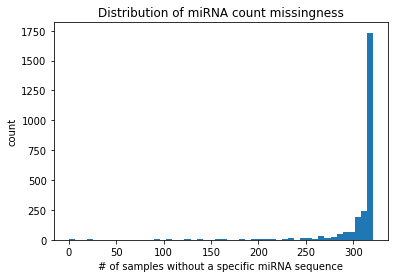

In [16]:
# miRNA count missingness
num_missing_seq = gm_full.isna().sum(axis = 1)
plt.hist(num_missing_seq,bins=50)
plt.title('Distribution of miRNA count missingness')
plt.ylabel('count')
plt.xlabel('# of samples without a specific miRNA sequence')
plt.savefig(os.path.join(plot_path, 'miRNA_missingness.png'))

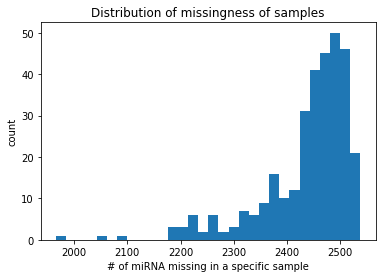

In [17]:
# missingness of the samples
num_missing_samp = gm_full.isna().sum(axis = 0)
plt.hist(num_missing_samp, bins=30)
plt.title('Distribution of missingness of samples')
plt.ylabel('count')
plt.xlabel('# of miRNA missing in a specific sample')
plt.savefig(os.path.join(plot_path, 'sample_missingness.png'))

We have noticed that the index of the gene matrix include the name of the miRNA. So we extracted this information into a nicer form.


In [18]:
gm_full.index[0]

'cqu-miR-10-5p:MIMAT0014404:Cul'

In [19]:
split_info_full = gm_full.index.to_series().apply(lambda x: x.split(':')).reset_index(drop=True)
ids_full = split_info_full.apply(lambda x: x[0])
ids_full_extracted = ids_full.apply(lambda x: x.partition('-')[2])
ids_full_extracted

0         miR-10-5p
1          mir-451a
2       miR-7019-3p
3           miR159b
4           miR-26b
           ...     
2545       mir-125a
2546         miR-34
2547       miR-519b
2548         miR535
2549       mir-204b
Length: 2550, dtype: object


To avoid any potential influence on our downstream analysis, we have removed all the sequences that is missing in any of the samples. Before removing, we had 2550 sequences and 400 after removing.

In [32]:
gm = pd.read_csv('../data/out/gene_matrix.tsv', sep='\t', index_col=0)
# clean up the index
gm.index = gm.index.str.slice(0,30)
gm.head()

,SRR1568478,SRR1568692,SRR1568530,SRR1568514,SRR1568600,SRR1568543,SRR1568669,SRR1568507,SRR1568430,SRR1568498,SRR1568655,SRR1568734,SRR1568427,SRR1568716,SRR1568497,SRR1568414,SRR1568385,SRR1568492,SRR1568556,SRR1568620,SRR1568395,SRR1568528,SRR1568717,SRR1568572,SRR1568691,SRR1568437,SRR1568479,SRR1568681,SRR1568689,SRR1568707,SRR1568587,SRR1568562,SRR1568643,SRR1568456,SRR1568704,SRR1568722,SRR1568416,SRR1568579,SRR1568744,SRR1568644,SRR1568690,SRR1568484,SRR1568464,SRR1568490,SRR1568534,SRR1568499,SRR1568483,SRR1568721,SRR1568398,SRR1568705,SRR1568506,SRR1568404,SRR1568580,SRR1568555,SRR1568656,SRR1568712,SRR1568406,SRR1568463,SRR1568738,SRR1568450,SRR1568408,SRR1568364,SRR1568550,SRR1568602,SRR1568381,SRR1568684,SRR1568601,SRR1568596,SRR1568468,SRR1568676,SRR1568622,SRR1568469,SRR1568432,SRR1568539,SRR1568746,SRR1568625,SRR1568525,SRR1568559,SRR1568652,SRR1568458,SRR1568441,SRR1568419,SRR1568565,SRR1568646,SRR1568457,SRR1568584,SRR1568415,SRR1568516,SRR1568422,SRR1568470,SRR1568654,SRR1568661,SRR1568465,SRR1568517,SRR1568599,SRR1568701,SRR1568438,SRR1568389,SRR1568386,SRR1568583,SRR1568648,SRR1568650,SRR1568663,SRR1568575,SRR1568371,SRR1568626,SRR1568485,SRR1568667,SRR1568666,SRR1568372,SRR1568674,SRR1568683,SRR1568753,SRR1568535,SRR1568461,SRR1568699,SRR1568685,SRR1568376,SRR1568755,SRR1568561,SRR1568725,SRR1568383,SRR1568501,SRR1568671,SRR1568751,SRR1568375,SRR1568613,SRR1568529,SRR1568476,SRR1568545,SRR1568627,SRR1568503,SRR1568718,SRR1568636,SRR1568393,SRR1568730,SRR1568682,SRR1568703,SRR1568594,SRR1568402,SRR1568467,SRR1568547,SRR1568576,SRR1568394,SRR1568508,SRR1568426,SRR1568673,SRR1568515,SRR1568418,SRR1568447,SRR1568731,SRR1568749,SRR1568455,SRR1568756,SRR1568608,SRR1568688,SRR1568687,SRR1568540,SRR1568452,SRR1568665,SRR1568544,SRR1568743,SRR1568396,SRR1568384,SRR1568578,SRR1568604,SRR1568527,SRR1568489,SRR1568401,SRR1568493,SRR1568500,SRR1568714,SRR1568742,SRR1568660,SRR1568424,SRR1568590,SRR1568570,SRR1568379,SRR1568519,SRR1568512,SRR1568710,SRR1568551,SRR1568713,SRR1568482,SRR1568511,SRR1568397,SRR1568524,SRR1568399,SRR1568538,SRR1568629,SRR1568573,SRR1568459,SRR1568605,SRR1568453,SRR1568589,SRR1568495,SRR1568624,SRR1568537,SRR1568702,SRR1568513,SRR1568536,SRR1568480,SRR1568591,SRR1568588,SRR1568607,SRR1568679,SRR1568520,SRR1568651,SRR1568533,SRR1568635,SRR1568488,SRR1568554,SRR1568697,SRR1568546,SRR1568571,SRR1568680,SRR1568726,SRR1568592,SRR1568370,SRR1568523,SRR1568727,SRR1568460,SRR1568531,SRR1568649,SRR1568711,SRR1568686,SRR1568387,SRR1568475,SRR1568390,SRR1568558,SRR1568409,SRR1568633,SRR1568481,SRR1568510,SRR1568700,SRR1568487,SRR1568400,SRR1568552,SRR1568741,SRR1568614,SRR1568581,SRR1568698,SRR1568569,SRR1568474,SRR1568728,SRR1568733,SRR1568542,SRR1568526,SRR1568634,SRR1568577,SRR1568750,SRR1568737,SRR1568557,SRR1568748,SRR1568363,SRR1568445,SRR1568715,SRR1568440,SRR1568658,SRR1568695,SRR1568439,SRR1568723,SRR1568504,SRR1568709,SRR1568623,SRR1568449,SRR1568740,SRR1568407,SRR1568729,SRR1568434,SRR1568736,SRR1568471,SRR1568522,SRR1568612,SRR1568444,SRR1568616,SRR1568560,SRR1568619,SRR1568366,SRR1568747,SRR1568672,SRR1568433,SRR1568724,SRR1568611,SRR1568615,SRR1568428,SRR1568518,SRR1568598,SRR1568706,SRR1568369,SRR1568745,SRR1568548,SRR1568448,SRR1568553,SRR1568754,SRR1568677,SRR1568735,SRR1568443,SRR1568425,SRR1568368,SRR1568693,SRR1568603,SRR1568670,SRR1568678,SRR1568653,SRR1568732,SRR1568585,SRR1568505,SRR1568720,SRR1568541,SRR1568462,SRR1568388,SRR1568593,SRR1568454,SRR1568563,SRR1568486,SRR1568378,SRR1568708,SRR1568567,SRR1568640,SRR1568436,SRR1568377
miRNAs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mir-10-5p,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.

In [33]:
gm_full.shape

(2550, 322)

In [34]:
gm.shape

(400, 322)

In [35]:
gm.isna().sum().sum()

0

In [37]:
gm_reind = gm.T
gm_reind.head()

miRNAs,mir-10-5p,mir-100,mir-100-5p,mir-100b,mir-101,mir-101b,mir-101b-3p,mir-101c,mir-103a,mir-106b,mir-106b-3p,mir-107b,mir-10b,mir-10b-5p,mir-10c,mir-10c-5p,mir-10d,mir-1180,mir-1180-3p,mir-1198-5p,mir-122,mir-122-5p,mir-122a-5p,mir-122b,mir-124,mir-124b,mir-124e-3p,mir-125-3p,mir-125a,mir-125b,mir-125b-1,mir-125b-2-3p,mir-125b-3p,mir-125c,mir-126-3p,mir-126-5p,mir-1260,mir-1264,mir-127,mir-1273g-3p,mir-1273h-5p,mir-1285,mir-1285-3p,mir-1285-5p,mir-1285a,mir-129-1-3p,mir-1296-5p,mir-1298,mir-1298-3p,mir-129a-5p,mir-129b,mir-129b-3p,mir-130,mir-1303,mir-1307,mir-130a,mir-130a-3p,mir-130b-3p,mir-130c-3p,mir-130d-3p,mir-133a-3p,mir-133c,mir-133c-3p,mir-136-3p,mir-139,mir-140-3p,mir-142-5p,mir-142a-5p,mir-143,mir-143-3p,mir-144,mir-144-3p,mir-144-5p,mir-145-3p,mir-145-5p,mir-145a-3p,mir-146-5p,mir-146a-5p,mir-148,mir-148-3p,mir-148a,mir-148a-3p,mir-148b,mir-148b-3p,mir-149,mir-150-3p,mir-151-3p,mir-151a,mir-151a-3p,mir-152-3p,mir-152a,mir-15a,mir-15a-5p,mir-15b-5p,mir-15c-5p,mir-16,mir-16-2-3p,mir-1692,mir-17-3p,mir-181c,mir-181c-5p,mir-181d,mir-182,mir-182-5p,mir-1839-5p,mir-184,mir-1843b-3p,mir-1843b-5p,mir-185,mir-186,mir-18b-3p,mir-191-5p,mir-1911-5p,mir-1912,mir-192-5p,mir-193-3p,mir-193b,mir-193b-3p,mir-194b-5p,mir-195,mir-197-3p,mir-1981-5p,mir-199-3-3p,mir-199a-5p,mir-199b-3p,mir-19c,mir-19d,mir-204,mir-204-3p,mir-204b,mir-208b-3p,mir-20b,mir-21,mir-210,mir-210-3p,mir-211,mir-211-5p,mir-215,mir-215-5p,mir-219-1-3p,mir-219-3p,mir-219-5p,mir-219a,mir-219a-3p,mir-21a-5p,mir-22,mir-22-3p,mir-22-5p,mir-221,mir-221-3p,mir-223,mir-223-3p,mir-22a,mir-22a-3p,mir-22b,mir-22b-3p,mir-235,mir-235-3p,mir-238,mir-23a,mir-23b,mir-23b-3p,mir-25,mir-26-5p,mir-263a,mir-263a-5p,mir-26a,mir-26a-2-5p,mir-26b,mir-26d-5p,mir-276a,mir-277,mir-2779,mir-2797d,mir-279a,mir-27a-3p,mir-27b-3p,mir-27c,mir-27c-3p,mir-27d,mir-27e,mir-28-3p,mir-281-2-5p,mir-296,mir-298-5p,mir-29a,mir-29a-3p,mir-29b,mir-29c-3p,mir-29c-5p,mir-300-3p,mir-301b,mir-3050,mir-3057-5p,mir-3078-5p,mir-30a,mir-30a-3p,mir-30a-5p,mir-30b,mir-30c-2,mir-30c-2-3p,mir-30c-5p,mir-30d,mir-30d-3p,mir-30e-3p,mir-30e-5p,mir-30f-3p,mir-30g,mir-31,mir-315,mir-320,mir-320b,mir-320d,mir-322-3p,mir-324-3p,mir-326,mir-328,mir-33,mir-330-3p,mir-335,mir-337-5p,mir-338,mir-338-3p,mir-338-5p,mir-339,mir-339-3p,mir-339-5p,mir-339a,mir-33b,mir-34,mir-34-5p,mir-340-5p,mir-344b-3p,mir-344d-3p,mir-345,mir-34a-5p,mir-34b,mir-34b-3p,mir-34b-5p,mir-34c,mir-34c-3p,mir-34c-5p,mir-351-5p,mir-3552,mir-35b,mir-35g,mir-361-3p,mir-361-5p,mir-3615,mir-3620-5p,mir-363,mir-363-3p,mir-3688-3p,mir-375,mir-378,mir-378a-5p,mir-378b,mir-378c,mir-378d,mir-378i,mir-39-3p,mir-3964,mir-3970,mir-40,mir-40-3p,mir-410-3p,mir-412-5p,mir-423-3p,mir-423-5p,mir-425-5p,mir-434-3p,mir-434-5p,mir-451,mir-4770,mir-483,mir-486a-5p,mir-488-5p,mir-490-5p,mir-497,mir-499-5p,mir-500,mir-500-1,mir-500-2,mir-500a-3p,mir-501,mir-501-3p,mir-502,mir-502-3p,mir-505-3p,mir-5096,mir-5099,mir-5100,mir-5108,mir-5119,mir-532-3p,mir-532-5p,mir-54,mir-540-3p,mir-541-5p,mir-548a,mir-548aa,mir-548ac,mir-548ad-5p,mir-548ae-3p,mir-548aq-3p,mir-548ar-5p,mir-548ay-5p,mir-548az-5p,mir-548b,mir-548b-5p,mir-548ba,mir-548c-5p,mir-548d-5p,mir-548h,mir-548v,mir-548z,mir-551,mir-551b,mir-574,mir-582,mir-582-3p,mir-584-5p,mir-589,mir-592,mir-598,mir-619-5p,mir-629,mir-652-3p,mir-654-3p,mir-664-3p,mir-664-5p,mir-664a,mir-6651-5p,mir-666-3p,mir-666-5p,mir-672,mir-674,mir-676-3p,mir-6858-5p,mir-767,mir-769,mir-769-5p,mir-770-3p,mir-7b-5p,mir-8,mir-81,mir-86-5p,mir-872,mir-873-3p,mir-873a-3p,mir-874,mir-879-5p,mir-885-5p,mir-92,mir-9226,mir-9277,mir-92a,mir-92a-3p,mir-92b,mir-92b-3p,mir-92c,mir-92c-3p,mir-92d,mir-92d-3p,mir-93,mir-941,mir-95,mir-98,mir-99,mir-99a,mir-99a-3p,mir-99b,mir-99b-5p,mir-9a-5p,mir-9a-7-3p,mir-9b,mir-9b-5p,mir1511,mir159a,mir159b,mir159b-3p.1,mir159c,mir159c-3p,mir161-5p.1,mir166b,mir166e,mir166g,mir166h-3p,mir166s,mir168a-5p,mir168b-5p,mir396c,mir5054,mir5072,mir5139,mir6300,mir6478,mir8175,mir894,mir951
SRR1568478,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,

Finally, before more in-depth analysis, we wanted to know the rough distribution of values and its correlation with some of the basic numerical features for each sequence and hoping to find some interesting trends. 


In [38]:
selected_ft = sra[['Run','CONDITION','expired_age', 'PMI', 'PlaqueTotal', 'TangleTotal',
                   'Braak score', 'sn_depigmentation']]
selected_ft = selected_ft.replace({'sn_depigmentation':{'none':0, 'nan':0, 'mild':1, 'moderate':2, 'severe':3},
                                   'Braak score':{'0':0, 'I':1, 'II':2, 'III':3, 'IV':4, 'V':5, 
                                                  'VI':6}}).set_index('Run')
alz_ft = selected_ft[selected_ft.CONDITION=='Alzheimer\'s Disease'].drop('CONDITION', axis=1)
park_ft = selected_ft[selected_ft.CONDITION=='Parkinson\'s Disease'].drop('CONDITION', axis=1)

alz_tbl = alz_ft.merge(gm_reind, left_index=True, right_index=True, how='inner')
park_tbl = park_ft.merge(gm_reind, left_index=True, right_index=True, how='inner')

num_fts = 6
alz_gm = alz_tbl.iloc[:, num_fts:]
park_gm = park_tbl.iloc[:, num_fts:]

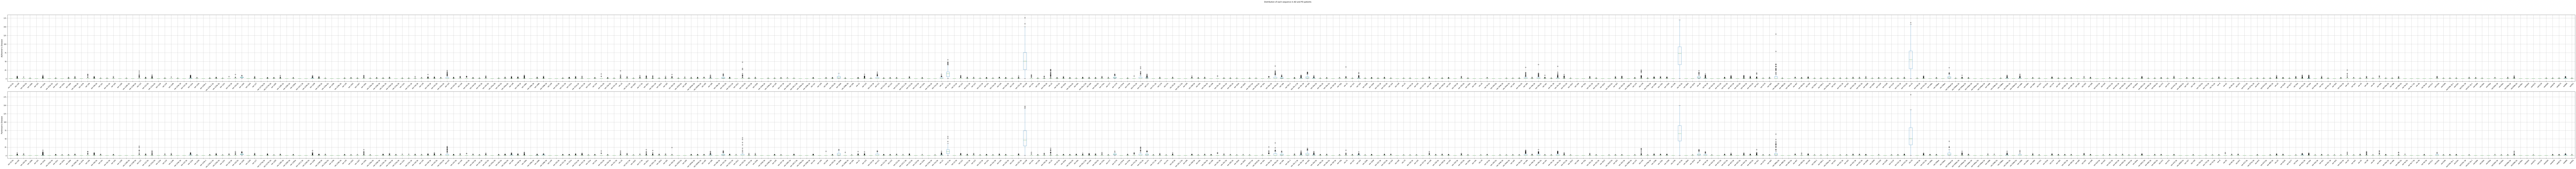

In [39]:
fig, axes= plt.subplots(nrows=2, ncols=1, figsize=(240, 16))
alz_gm.boxplot(ax = axes.flatten()[0])
axes.flatten()[0].set_xticklabels(alz_gm.columns, rotation=45)
park_gm.boxplot(ax = axes.flatten()[1])
axes.flatten()[1].set_xticklabels(park_gm.columns, rotation=45)
rows = ['Alzheimer\'s Disease','Parkinson\'s Disease']
for ax, row in zip(axes, rows):
    ax.set_ylabel(row, rotation=90, size='large')
fig.tight_layout()
fig.suptitle('Distribution of each sequence in AD and PD patients ')
fig.subplots_adjust(top=0.9)
fig.savefig(os.path.join(plot_path, 'miRNA_distr.png'))

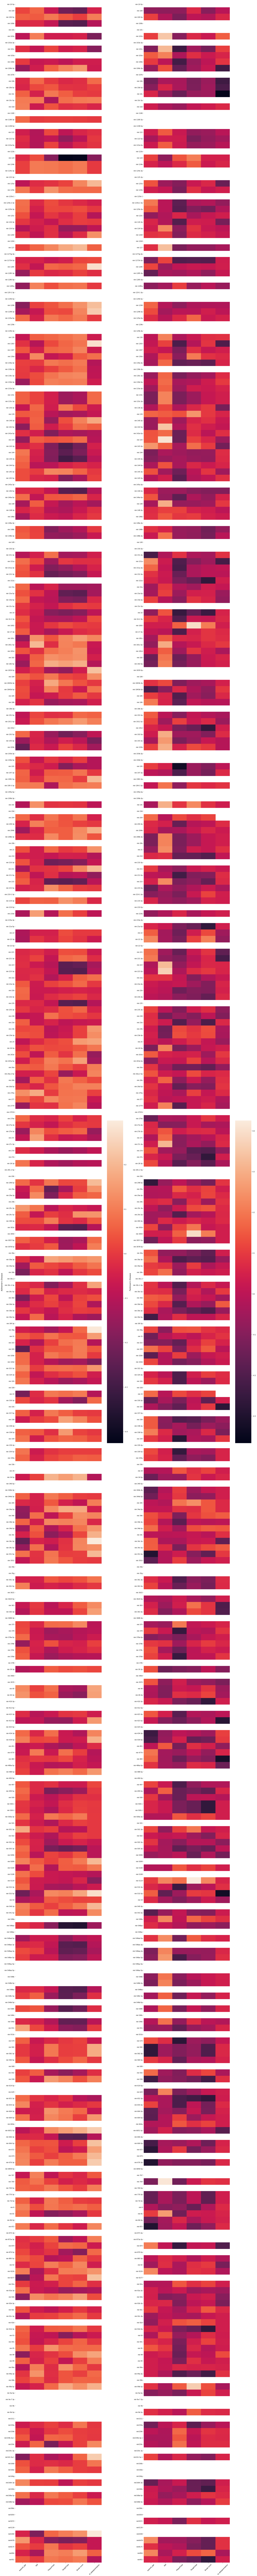

In [65]:
# Note that we have some blank rows which represent NaN correlations. It is because the values did not change
def get_corr_df(num_fts, fts_names, tbl):
    corr_df = pd.DataFrame()
    for i in range(num_fts):
        corr = tbl[tbl.columns[num_fts:]].apply(lambda x: x.corr(tbl.iloc[:,i]))
        corr_df[fts_names[i]] = corr
    return corr_df


fts_names = selected_ft.drop('CONDITION', axis=1).columns
tbl_arr = [alz_tbl, park_tbl]
cols = ['Alzheimer\'s Disease','Parkinson\'s Disease']
fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(24, 240))
ind = 0
for tbl in tbl_arr:
    corr_df = get_corr_df(num_fts, fts_names, tbl)
    sn.heatmap(corr_df, ax = axes.flatten()[ind])
    axes.flatten()[ind].set_xticklabels(fts_names, rotation=45)
    ind = ind+1

for ax, col in zip(axes, cols):
    ax.set_ylabel(col, rotation=90, size='large')
fig.tight_layout()
#fig.suptitle('Correlation of each gene with selected features ')
#fig.subplots_adjust(top=0.95)
fig.savefig(os.path.join(plot_path, 'miRNA_corr.png'))